In [9]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
import sys
# sys.path.insert(1, '../src')
import algorithm as al

In [10]:
print(cv2.getBuildInformation())


General configuration for OpenCV 4.10.0 =====================================
  Version control:               unknown

  Extra modules:
    Location (extra):            /tmp/pip-install-q_5601f_/opencv-contrib-python-headless_8899128e35a84dcb90525b8113d5a9a5/opencv_contrib/modules
    Version control (extra):     unknown

  Platform:
    Timestamp:                   2024-11-20T04:43:55Z
    Host:                        Linux 6.8.0-45-generic x86_64
    CMake:                       3.31.0
    CMake generator:             Ninja
    CMake build tool:            /usr/bin/ninja
    Configuration:               Release

  CPU/HW features:
    Baseline:                    SSE SSE2 SSE3
      requested:                 SSE3
    Dispatched code generation:  SSE4_1 SSE4_2 FP16 AVX AVX2 AVX512_SKX
      requested:                 SSE4_1 SSE4_2 AVX FP16 AVX2 AVX512_SKX
      SSE4_1 (16 files):         + SSSE3 SSE4_1
      SSE4_2 (1 files):          + SSSE3 SSE4_1 POPCNT SSE4_2
      FP16 (0 file

In [11]:
sample_input = '/home/saratoga/swt2_data/shegreat_0020.png'
sample_input_line = '/home/saratoga/swt2_data/line.png'
sample_input_line_2 = '/home/saratoga/swt2_data/line2.png'
# sample_input = '/home/saratoga/cs670-manga/inputs/TsubasaNoKioku/070.jpg'
# sample_input_line = sample_input

# sample_input = '/home/saratoga/swt2_data/AisazuNihaIrarenai-009.jpg'
# sample_input_line = sample_input

def visualize(poly, background):
    bg = background.copy()
    # print(chains.shape)
    # print(np.array(poly).shape)
    cv2.polylines(bg, poly, True, (0, 255, 0), 2)
    # plt.clf()
    plt.figure(figsize=(10, 10))
    plt.imshow(bg[:bg.shape[0], :bg.shape[1]])
    return plt

def visualize_method(img, method, background=None, output_name=None):
    bg = img if background is None else background
    chars, chains, seperated = method.process(img)
    # print(chars)
    # for char in chars:
    #     print(char.shape)
        
    plt = visualize(chars if seperated else chains, bg)
    if output_name is not None:
        plt.savefig(output_name + '-' + method.__class__.__name__ + '.png')

img = cv2.imread(sample_input)
line = cv2.imread(sample_input_line)
line2 = cv2.imread(sample_input_line_2)

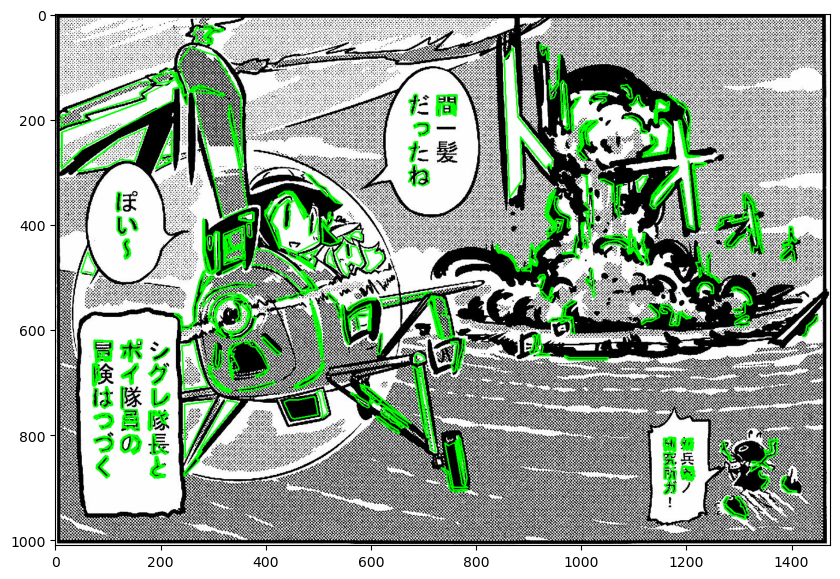

In [29]:
mode = al.Text_ER()
visualize_method(line, mode, img)

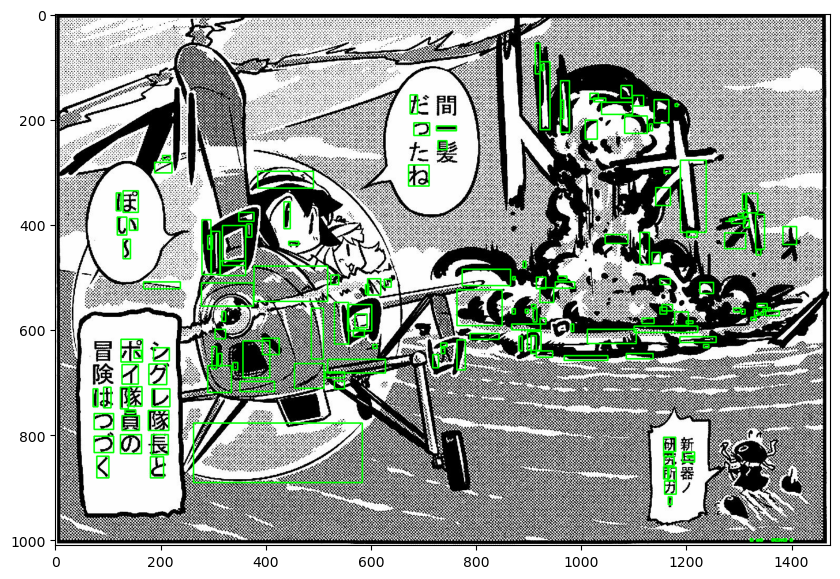

In [30]:
visualize_method(line, al.Text_SWT(), img)

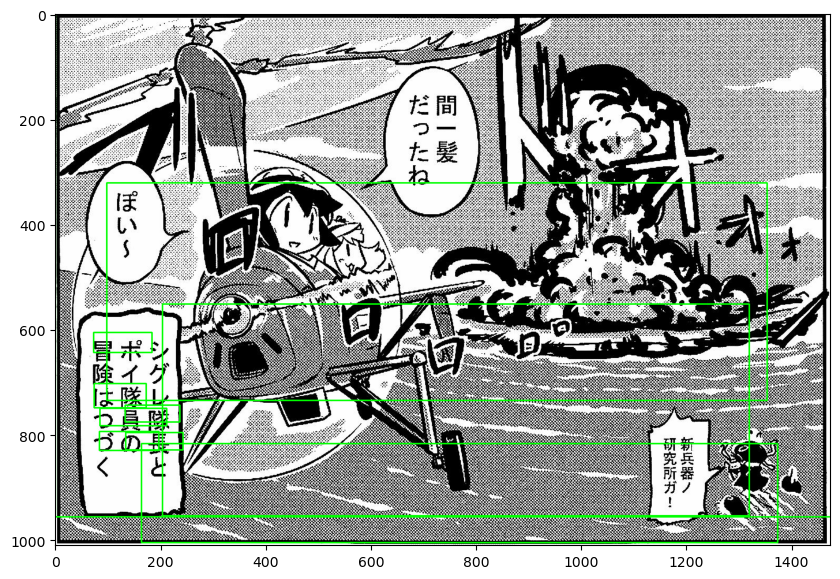

In [31]:
# print(dir(al))
visualize_method(line, al.Text_CNNTextBoxes(), img)

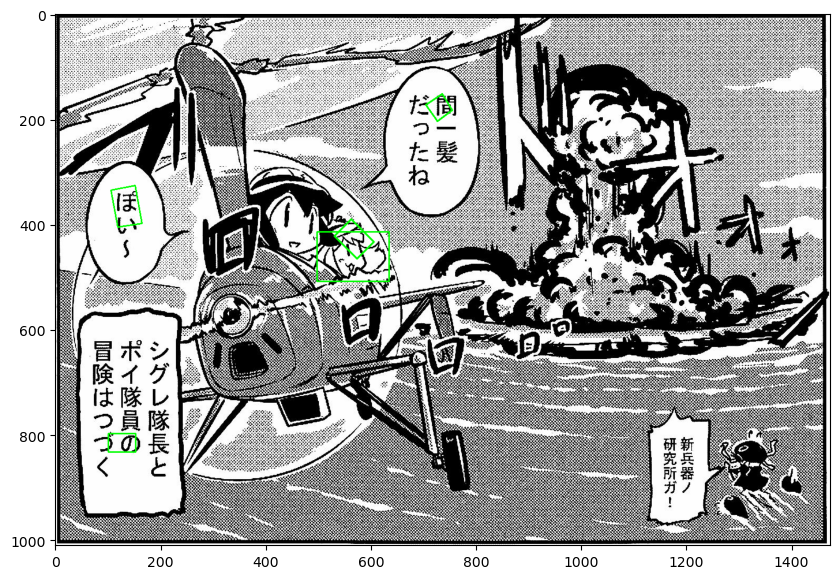

In [32]:
visualize_method(line, al.DNN_DB(), img)

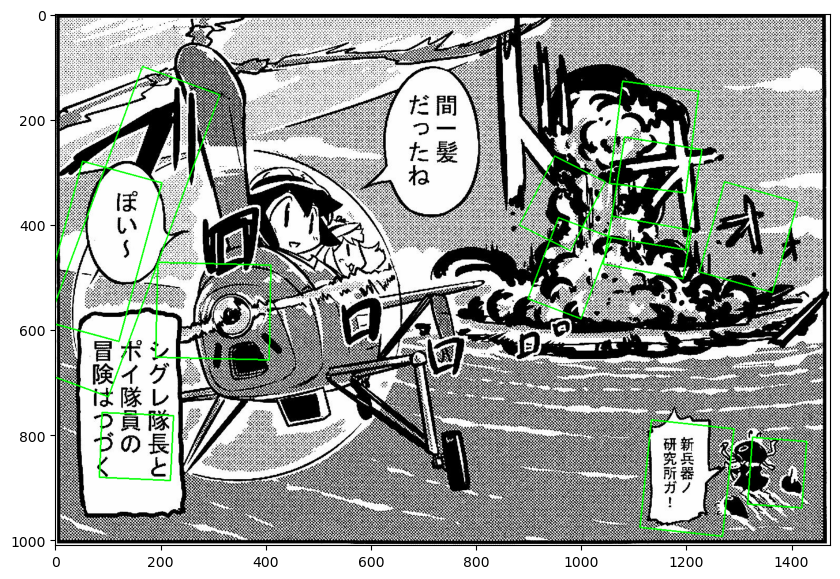

In [33]:
visualize_method(line, al.DNN_EAST(), img)

In [9]:
import glob
from pathlib import Path
import algorithm as al

def run(img_name, root, out_base):
    p = Path(img_name).relative_to(root)
    img = cv2.imread(img_name)
    line = img
    out = out_base / p
    print(img_name, '=>', out)
    out.parent.mkdir(parents=True, exist_ok=True)
    out.parents[1]
    out = str(out)
    return
    visualize_method(line, al.Text_ER(), img, out)
    visualize_method(line, al.Text_SWT(), img, out)
    visualize_method(line, al.Text_CNNTextBoxes(), img, out)
    visualize_method(line, al.DNN_DB(), img, out)
    visualize_method(line, al.DNN_EAST(), img, out)

base = '/home/saratoga/swt2_data/mantra_output/'
root = '/home/saratoga/swt2_data/open-mantra-dataset/'
test_set = glob.glob('/home/saratoga/swt2_data/open-mantra-dataset/images/**/*.jpg', recursive=True)

# print(test_set)
# for test in test_set:
#     run(test, root, base)
    # break


In [10]:
import json
with open('/home/saratoga/swt2_data/open-mantra-dataset/annotation.json', 'r') as fd:
    anno = json.loads(fd.read())

In [11]:
from pathlib import Path
from shapely import Polygon, intersection, union, normalize, MultiPolygon, make_valid
import numpy as np
# method.process(img)
def convert_polygon_to_points(p):
    pts = np.array([x for x in p.exterior.coords][:-1], dtype=np.int32)
    pts.reshape((-1, 1, 2))
    # print(pts)
    return pts

def condense(bbs):
    while True:
        condensed = []
        for bb in bbs:
            if not bb.area > 0:
                continue
            if not bb.is_valid:
                print("WARN invalid polygon; Ignoring {}".format(bb))
                continue
            count = 0
            for i in range(len(condensed)):
                c = condensed[i]
                if bb.overlaps(c) and bb.intersects(c):
                    condensed[i] = normalize(c.union(bb))
                    assert condensed[i].geom_type == "Polygon", "{} intersecs {} seems impossible {}".format(c, bb, condensed[i])
                else:
                    count += 1
            if count == len(condensed):
                condensed.append(bb)
                
        if len(bbs) == len(condensed):
            break
        bbs = condensed
    return condensed

def fix_invalid_polygon(p1):
    # print(f"{p1.is_valid}")
    if p1.is_valid:
        # print("No need to fix")
        return [p1]
    p2 = make_valid(p1)
    # print(f"{p2}")
    if p2.geom_type == 'MultiPolygon':
        # print("Fixed by splitting")
        return [*p2.geoms]
    elif p2.geom_type == 'GeometryCollection':
        return [x for x in p2.geoms if x.geom_type == 'Polygon']
    else:
        assert False, (f"Don't know how to fix {p2.geom_type}: {p2}")
    return []


def collide(image_name, method, known_bbs):
    img = cv2.imread(image_name)
    chars, chains, sep = method.process(img)
    tp = []
    # fp = []
    # fn = []
    chars_fix = [x for char in chars for x in fix_invalid_polygon(Polygon(char))]
    polys = condense([Polygon(bb) for bb in chars_fix])
    # print(polys)
    bbs = condense([Polygon(bb) for bb in known_bbs])
    a = np.sum([poly.area for poly in polys])
    b = np.sum([bb.area for bb in bbs])
    for poly in polys:
        match = 0
        for bb in bbs:
            intersect = normalize(poly.intersection(bb))
            # print("Intersect", intersect.area)
            match += intersect.area
            # missing += bb.area - a
        # print(match, missing, poly.area)
        # wrong_match = poly.area - match
        # assert wrong_match > 0
        # if wrong_match < 0:
        #     print("WARN wrong_match", wrong_match)
        #     wrong_match = 0

        tp.append(match)
        # fp.append(wrong_match)
        # fn.append(missing)

    tps = np.sum(tp)
    fps = a - tps
    fns = b - tps
    if fps < 0:
        print("WARN fps", fps)
        fps = 0
    if fns < 0:
        print("WARN fns", fns)
        fns = 0
    # visualize([convert_polygon_to_points(poly) for poly in polys], img)
    # visualize([convert_polygon_to_points(poly) for poly in bbs], img)

    return (tps, fps, fns)

def stats(x):
    tp, fp, fn = x
    # if tp < 0:
    #     print("WARN tp < 0")
    # if fp < 0:
    #     print("WARN fp < 0")
    # if fn < 0:
    #     print("WARN fn < 0")
    precision = 0 if (tp + fp == 0) else tp / (tp + fp)
    recall = 0 if (tp + fn == 0) else tp / (tp + fn)
    f1 =  0 if precision + recall == 0 else (2 * precision * recall) / (precision + recall)
    return (precision, recall, f1)

def run_mass(TARGET=None):
    root = '/home/saratoga/swt2_data/open-mantra-dataset/'
    total = np.array((0., 0., 0.))
    depth = 0
    for book in anno:
        title = book["book_title"]
        for page in book["pages"]:
            depth += 1
            if TARGET is not None and depth != TARGET:
                continue
            page_no = page["page_index"]
            img_path = Path(root) / page["image_paths"]["ja"]
            bbs = []
            for text in page["text"]:
                rect = (text["x"], text["y"], text["w"], text["h"])
                bbs.append(al.rect_to_points(rect))
            # print(bb)
            m = al.Text_ER()
            # al.enable_CUDA(m)
            z = collide(img_path, m, bbs)
            total += stats(z)
            if depth == TARGET:
                return total
    return total/depth
                

print(run_mass(1))
# DB [0.74591527 0.05696854 0.09671098]

# EAST [0.10752163 0.01610562 0.02531817]
# SWT [0.2821221  0.00052111 0.00103782]
# ER [0.11604181 0.00929692 0.01539698]
# TextBoxes [0.10149707 0.71080543 0.1654614 ]

# Improved
# DB [0.74626367 0.05491366 0.0938761 ]
# EAST [0.10752163 0.01610562 0.02531817]
# ER [0.11335229 0.00956246 0.01550481]
# SWT [0.28213893 0.00051337 0.00102253]
# TextBoxes [0.10692051 0.51372485 0.16243599]

# Correct number
# DB [0.74605163 0.22481251 0.32306157]
# EAST [0.10745574 0.03709625 0.04767068]
# ER [0.11315557 0.84735446 0.19142319]
# SWT [0.28196898 0.13095646 0.16871642]
# TextBoxes [0.10660832 0.86393177 0.18541365]

[0.09528374 0.68208026 0.16720908]


In [12]:
cv2.cuda.getCudaEnabledDeviceCount()

1

In [13]:
# Edge cases see shapely_debugging.ipynb

/tmp/ipykernel_157925/3059661228.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('../erika.pth'))


/home/saratoga/swt2_data/shegreat_0020.png tensor(257.3391, device='cuda:0') tensor(-22.0382, device='cuda:0')


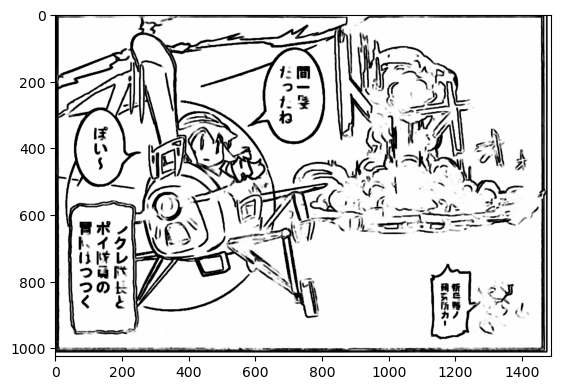

In [28]:
import torch
import cv2
import numpy as np
import sys
from pathlib import Path
from sklearn.preprocessing import normalize
root = '/home/saratoga/cs670-manga/'
sys.path.insert(0, str(root))
from model_torch import res_skip

model = res_skip()
model.load_state_dict(torch.load('../erika.pth'))
model.cuda()
model.eval()

def experimental_genline(img):
    with torch.inference_mode():
        im = cv2.imread(img, cv2.IMREAD_GRAYSCALE)
        # Batching
        rows = int(np.ceil(im.shape[0]/16)) * 16
        cols = int(np.ceil(im.shape[1]/16)) * 16
        # unsqueeze
        patch = np.ones((1, 1, rows, cols), dtype=np.float32)
        patch[0, 0, 0:im.shape[0], 0:im.shape[1]] = im

        tensor = torch.from_numpy(patch).cuda()
        y = model(tensor)
        print(img, torch.max(y), torch.min(y))
        line = y.cpu().numpy()[0, 0, :, :]

        # line = cv2.bitwise_not((line - line.mean()) / line.std())
        line[line > 255] = 255
        line[line < 0] = 0
        # line = line - line.min()
        # line = line / line.max()
        line_gray = line.astype(np.uint8)
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (4, 4))
        return cv2.cvtColor(cv2.erode(line_gray, kernel), cv2.COLOR_GRAY2RGB)


line = experimental_genline(sample_input)
plt.imshow(line)
